# Basics with string sequence

* Find this notebook at `EpyNN/nnlive/dummy_string/train.ipynb`.
* Regular python code at `EpyNN/nnlive/dummy_string/train.py`.

In this notebook we will review:

* Handling sequential string data.
* Training of Feed-Forward (FF) and recurrent networks (RNN, LSTM, GRU).
* Differences between decisions and probabilities and related functions.

Please see the following if you get lost:

* [Fully Connected (Dense)](../../Dense.html)
* [Recurrent Neural Network (RNN)](../../RNN.html)
* [Long Short-Term Memory (LSTM)](../../LSTM.html)
* [Gated Recurrent Unit (GRU)](../../GRU.html)

## Environment and data

Follow [this link](prepare_dataset.ipynb) for details about data preparation.

Briefly, these dummy string data consists of sequence of characters. Sample features are each represented by one sequence and can be either associated with a positive or negative label.

Positive sequences are met when the first element in the sequence is equal to the last element in this same sequence, and reciprocally.

In [1]:
# EpyNN/nnlive/dummy_string/train.ipynb
# Standard library imports
import random

# Related third party imports
import numpy as np

# Local application/library specific imports
import nnlibs.initialize
from nnlibs.commons.io import one_hot_decode_sequence
from nnlibs.commons.maths import relu, softmax
from nnlibs.commons.library import (
    configure_directory,
    read_model,
)
from nnlibs.network.models import EpyNN
from nnlibs.embedding.models import Embedding
from nnlibs.flatten.models import Flatten
from nnlibs.rnn.models import RNN
from nnlibs.gru.models import GRU
from nnlibs.lstm.models import LSTM
from nnlibs.dense.models import Dense
from prepare_dataset import prepare_dataset
from settings import se_hPars


########################## CONFIGURE ##########################
random.seed(1)

np.set_printoptions(threshold=10)

np.seterr(all='warn')

configure_directory()


############################ DATASET ##########################
X_features, Y_label = prepare_dataset(N_SAMPLES=480)

Let's control what we retrieved.

In [2]:
print(len(X_features))
print(len(X_features[0]))
print(X_features[0])
print(Y_label[0])

480
12
['G', 'A', 'C', 'T', 'T', 'G', 'G', 'C', 'C', 'A', 'T', 'C']
0


We retrieved a set sample features describing ``480`` samples.

Each sample is described by ``12`` string features.

Herein the label is ``0`` because the first and last element are different.

## Feed-Forward (FF)

To compare Feed-Forward and recurrent networks, we are goign to train a simple Perceptron first.

### Embedding

The principle of [One-hot encoding of string features](prepare_dataset.ipynb#One-hot-encoding-of-string-features) was detailed before.

Briefly, we can not do math on string data. Therefore, the one-hot encoding process may be summarized as such:

* List of all words of size vocab_size. This basically answers: what is the number of distinct words we can find in your data?
* Each word is associated with one index in the range(0, vocab_size). This provides a word_to_idx encoder.
* For each word in one sample features, a zero array is initialized. This array is set to one at the index which is assigned to the word in the encoder.

This is achieved during instantiation of the *embedding* layer by setting up ``X_encode=True``.

In [3]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      X_encode=True,
                      Y_encode=True,
                      relative_size=(2, 1, 0))

Let's inspect some properties.

In [4]:
print(embedding.w2i)  # word_to_idx
print(embedding.dtrain.X[0])

print(embedding.i2w)  # idx_to_word
print(one_hot_decode_sequence(embedding.dtrain.X[0], embedding.i2w))

{'A': 0, 'C': 1, 'G': 2, 'T': 3}
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
{0: 'A', 1: 'C', 2: 'G', 3: 'T'}
['G', 'A', 'C', 'T', 'T', 'G', 'G', 'C', 'C', 'A', 'T', 'C']


Encoded sequences may be decoded as shown above.

### Flatten-Dense - Perceptron

Let's inspect the shape of the data.

In [5]:
print(embedding.dtrain.X.shape)

(320, 12, 4)


It contains 320 samples (m), each described by a sequence of 12 features (s) containing 4 elements (v).

12 features is the length of the sequences and 4 elements is the size of the vocabulary. Remember one-hot encoding makes a zero array of this size and sets 1 at the index corresponding to the word being encoded.

Still, the fully-connected or *dense* layer can only process bi-dimensionnal input arrays. That is the reason why we need to invoke a *flatten* layer in between the *embedding* and *dense* layer.

In [6]:
name = 'Flatten_Dense-2-softmax'

se_hPars['learning_rate'] = 0.001

flatten = Flatten()

dense = Dense(2, softmax)

layers = [embedding, flatten, dense]

model = EpyNN(layers=layers, name=name)

Initialize using most classically a *MSE* or *Binary Cross Entropy* loss function.

In [7]:
model.initialize(loss='BCE', seed=1, se_hPars=se_hPars.copy(), end='\r')

Train for hundred epochs.

In [8]:
model.train(epochs=50, init_logs=False)

Epoch 49 - Batch 0/0 - Accuracy: 0.731 Cost: 0.57021 - TIME: 1.36s RATE: 5.74e+03e/s TTC: 0s

+-------+----------+-------+----------+-------+-------+------------------------------------+
| epoch |  lrate   |       | accuracy |       |  BCE  |             Experiment             |
|       |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                    |
+-------+----------+-------+----------+-------+-------+------------------------------------+
|   0   | 1.00e-03 | 0.406 |  0.438   | 0.856 | 0.861 | 1630629259_Flatten_Dense-2-softmax |
|   5   | 1.00e-03 | 0.662 |  0.694   | 0.644 | 0.602 | 1630629259_Flatten_Dense-2-softmax |
|  10   | 1.00e-03 | 0.706 |  0.719   | 0.622 | 0.577 | 1630629259_Flatten_Dense-2-softmax |
|  15   | 1.00e-03 | 0.722 |  0.756   | 0.611 | 0.570 | 1630629259_Flatten_Dense-2-softmax |
|  20   | 1.00e-03 | 0.728 |  0.750   | 0.602 | 0.567 | 1630629259_Flatten_Dense-2-softmax |
|  25   | 1.00e-03 | 0.725 |  0.744   | 0.594 | 0.566 | 1630629259_Fl

Plot the results.

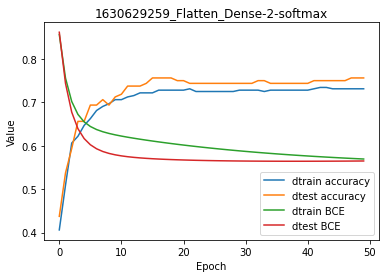

In [9]:
model.plot(path=False)

Strictly talking, the Perceptron seems to have converged in the good direction.

By reducing the learning rate, all other things being equal, we obtained greater accuracy, lower cost and smoother curves on the plot.

You may have observed something possibly counter-intuituve: the cost, which describes the mean difference between experimental and expected outputs, is different between the training and testing set whereas the accuracy is the same.

That's because accuracy compares **decisions** and labels, whereas the cost from the loss function compare **probabilities** and labels.

Let's take a break and understand the difference in addition to make clear some semantics.

### Difference between accuracy and cost

The question is: Can we expect identical costs for the training and testing set **if** the accuracy is identical for the training and testing set?

Let's compare what outputs the *dense* layer (A) to the set of sample label (Y).

In [10]:
# This is probability distributions for each sample. 
print(model.embedding.dtrain.A)
print(model.embedding.dtrain.A.shape)

# These are the labels we target
print(model.embedding.dtrain.Y) 
print(model.embedding.dtrain.Y.shape) 

[[0.6023828  0.3976172 ]
 [0.83563909 0.16436091]
 [0.79436824 0.20563176]
 ...
 [0.8179069  0.1820931 ]
 [0.75307446 0.24692554]
 [0.82516061 0.17483939]]
(320, 2)
[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]
(320, 2)


We have probabilities (A) versus binary values (Y).

To compute the accuracy, one need to convert probabilities to decision, as well as to retrieve single-digit labels.

In [11]:
print(np.argmax(model.embedding.dtrain.A, axis=1))

# Equivalent to calling model.embedding.dtrain.y directly
print(np.argmax(model.embedding.dtrain.Y, axis=1))

[0 0 0 ... 0 0 0]
[0 0 1 ... 1 0 0]


Then, accuracy is computed such as:

In [12]:
print ((np.argmax(model.embedding.dtrain.A, axis=1) == model.embedding.dtrain.y))
print ((np.argmax(model.embedding.dtrain.A, axis=1) == model.embedding.dtrain.y).mean())

[ True  True False ... False  True  True]
0.73125


The cost is computed from **probabilities, not from decisions**. This apart from the fact that accuracy and cost are simply two different functions.

To compute a cost, we first need to compute the loss, which provides information for each single probability in the array (A).

In [13]:
# This is the cost. It deals with "true" labels against probabilities

loss = model.training_loss(model.embedding.dtrain.Y, model.embedding.dtrain.A)

print(loss.shape)

(320,)


The cost is a form of average of the loss. Whereas the loss in an array from element-wise comparison between probabilities and label, the cost is a scalar which is an average per sample, itself an average of the element-wise loss for this sample.

In [14]:
print(loss.shape)          # Averaged for each sample
print(loss.mean().shape)   # Average of above - scalar

cost = loss.mean()

print(cost)

(320,)
()
0.56953060242346


Note that what is fed back in the network during the backward propagation phase is not the loss. It is the **derivative** of the loss.

In [15]:
dloss = model.training_loss(model.embedding.dtrain.Y, model.embedding.dtrain.A, deriv=True)

print(loss)
print(dloss)    # dloss is referred to as dA

[0.50686215 0.17955847 1.58166831 ... 1.70323721 0.28359117 0.19217723]
[[-0.83003697  0.83003697]
 [-0.59834443  0.59834443]
 [ 2.43153106 -2.43153106]
 ...
 [ 2.7458482  -2.7458482 ]
 [-0.66394497  0.66394497]
 [-0.60594264  0.60594264]]


The loss function and derivatives natively provided with EpyNN can be found in `EpyNN/nnlibs/commons/loss.py`.

The metrics natively provided with EpyNN can be found in `EpyNN/nnlibs/commons/metrics.py`.

## Recurrent Architectures

Herein, we are going to chain simple schemes based on recurrent architectures.

There are three most commonly cited recurrent layers:

* **Recurrent Neural Network (RNN)**: This is the most simple recurrent layer. It is composed of one to many recurrent units. Each cell performs a single activation which output the *hidden cell state* or simply *hidden state*.
* **Long Short-Term Memory (LSTM)**: By contrast with the RNN cell, the LSTM cell requires four activation which corresponds to three different gates: forget, input (two activations), and output. To compute the hidden cell state, it then requires a fifth activation. Note that in addition to the hidden cell state, there is another so-called cell *memory* state.
* **Gated Recurrent Unit (GRU)**: Compared to the LSTM cell, the GRU cell has only two gates: reset and update. Practically talking, GRU trains faster than LSTM and is reported to perform better on small dataset or shorter sequences. Both GRU and LSTM, however, are state-of-the art architecture to deal with sequential data.

See [here](nnlive/dummy_time/train.html#Recurrent-Neural-Network-(RNN)) for more detailed practical description or simply via the pages linked on top of this notebook.

### Embedding

In this example, we use the same setup than for Feed-Forward networks.

In [16]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      X_encode=True,
                      Y_encode=True,
                      relative_size=(2, 1, 0))

We can now chain the simplest schemes to train binary classifiers based on recurrent layers.

### RNN-Dense

The number of RNN units in the RNN layer is set to 1.

In [17]:
name = 'RNN-1_Dense-2-softmax'

se_hPars['learning_rate'] = 0.001

rnn = RNN(1)

dense = Dense(2, softmax)

layers = [embedding, rnn, dense]

model = EpyNN(layers=layers, name=name)

Initialize the model.

In [18]:
model.initialize(loss='BCE', seed=1, se_hPars=se_hPars.copy(), end='\r')

Train for 50 epochs.

In [19]:
model.train(epochs=10, init_logs=False)

Epoch 9 - Batch 0/0 - Accuracy: 0.734 Cost: 0.60911 - TIME: 0.79s RATE: 8.76e+02e/s TTC: 0s

+-------+----------+----------+-------+----------+-------+-------+----------------------------------+
| epoch |  lrate   |  lrate   |       | accuracy |       |  BCE  |            Experiment            |
|       |   RNN    |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                  |
+-------+----------+----------+-------+----------+-------+-------+----------------------------------+
|   0   | 1.00e-03 | 1.00e-03 | 0.572 |  0.494   | 0.673 | 0.688 | 1630629262_RNN-1_Dense-2-softmax |
|   1   | 1.00e-03 | 1.00e-03 | 0.584 |  0.500   | 0.660 | 0.672 | 1630629262_RNN-1_Dense-2-softmax |
|   2   | 1.00e-03 | 1.00e-03 | 0.597 |  0.525   | 0.649 | 0.658 | 1630629262_RNN-1_Dense-2-softmax |
|   3   | 1.00e-03 | 1.00e-03 | 0.650 |  0.581   | 0.640 | 0.646 | 1630629262_RNN-1_Dense-2-softmax |
|   4   | 1.00e-03 | 1.00e-03 | 0.691 |  0.688   | 0.632 | 0.636 | 1630629262_RNN-1_Dense-2

You may already note that results are virtually identical to just using a basic Perceptron, although slightly better.

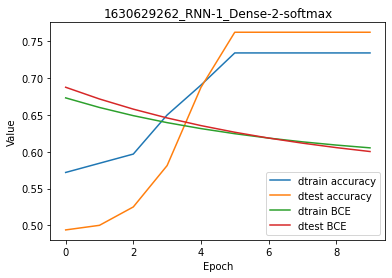

In [20]:
model.plot(path=False)

While the y-scale on the plot is a bit missleading when looking at the accuracy, there is no overfitting in there because the BCE cost is the same for both training and testing set at the end of the regression.

### LSTM-Dense

Let's now proceed with an *LSTM* layer composed of the 1 unit, all other things being equal.

In [21]:
name = 'LSTM-1_Dense-2-softmax'

se_hPars['learning_rate'] = 0.005

lstm = LSTM(1)

dense = Dense(2, softmax)

layers = [embedding, lstm, dense]

model = EpyNN(layers=layers, name=name)

Initialize the model.

In [22]:
model.initialize(loss='BCE', seed=1, se_hPars=se_hPars.copy(), end='\r')

Train for 50 epochs.

In [23]:
model.train(epochs=10, init_logs=False)

Epoch 9 - Batch 0/0 - Accuracy: 0.734 Cost: 0.57903 - TIME: 1.61s RATE: 4.48e+02e/s TTC: 0s

+-------+----------+----------+-------+----------+-------+-------+-----------------------------------+
| epoch |  lrate   |  lrate   |       | accuracy |       |  BCE  |            Experiment             |
|       |   LSTM   |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                   |
+-------+----------+----------+-------+----------+-------+-------+-----------------------------------+
|   0   | 5.00e-03 | 5.00e-03 | 0.734 |  0.762   | 0.619 | 0.610 | 1630629263_LSTM-1_Dense-2-softmax |
|   1   | 5.00e-03 | 5.00e-03 | 0.734 |  0.762   | 0.595 | 0.580 | 1630629263_LSTM-1_Dense-2-softmax |
|   2   | 5.00e-03 | 5.00e-03 | 0.734 |  0.762   | 0.586 | 0.567 | 1630629263_LSTM-1_Dense-2-softmax |
|   3   | 5.00e-03 | 5.00e-03 | 0.734 |  0.762   | 0.582 | 0.561 | 1630629263_LSTM-1_Dense-2-softmax |
|   4   | 5.00e-03 | 5.00e-03 | 0.734 |  0.762   | 0.580 | 0.557 | 1630629263_LSTM-

The accuracy metrics is simply identical to what we have seen with a simple *RNN*, which is much faster to compute. It is not significantly better than what we obtained from a simple Perceptron, itself way faster to compute than the *RNN* based network.

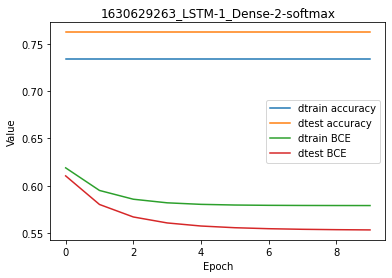

In [24]:
model.plot(path=False)

By contrast with the RNN-based network, we observe here a slight overfitting because the cost is lower for the training dataset compared to the testing dataset.

### GRU-Dense

Let's now proceed with a GRU layer, all other things being equal.

In [25]:
name = 'GRU-1_Dense-2-softmax'

se_hPars['learning_rate'] = 0.005

gru = GRU(1)

flatten = Flatten()

dense = Dense(2, softmax)

layers = [embedding, gru, dense]

model = EpyNN(layers=layers, name=name)

Initialize the network.

In [26]:
model.initialize(loss='BCE', seed=1, se_hPars=se_hPars.copy(), end='\r')

Train for 50 epochs.

In [27]:
model.train(epochs=10, init_logs=False)

Epoch 9 - Batch 0/0 - Accuracy: 0.734 Cost: 0.57987 - TIME: 1.06s RATE: 5.65e+02e/s TTC: 0s

+-------+----------+----------+-------+----------+-------+-------+----------------------------------+
| epoch |  lrate   |  lrate   |       | accuracy |       |  BCE  |            Experiment            |
|       |   GRU    |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                  |
+-------+----------+----------+-------+----------+-------+-------+----------------------------------+
|   0   | 5.00e-03 | 5.00e-03 | 0.734 |  0.762   | 0.609 | 0.600 | 1630629265_GRU-1_Dense-2-softmax |
|   1   | 5.00e-03 | 5.00e-03 | 0.734 |  0.762   | 0.590 | 0.575 | 1630629265_GRU-1_Dense-2-softmax |
|   2   | 5.00e-03 | 5.00e-03 | 0.734 |  0.762   | 0.583 | 0.565 | 1630629265_GRU-1_Dense-2-softmax |
|   3   | 5.00e-03 | 5.00e-03 | 0.734 |  0.762   | 0.581 | 0.560 | 1630629265_GRU-1_Dense-2-softmax |
|   4   | 5.00e-03 | 5.00e-03 | 0.734 |  0.762   | 0.580 | 0.558 | 1630629265_GRU-1_Dense-2

Plot the results.

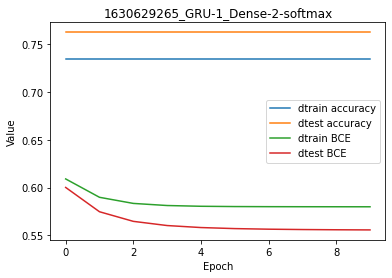

In [28]:
model.plot(path=False)

Overall, and using this dummy dataset made of string features, there is no significant metrcis/cost difference from the simple Perceptron to recurrent RNN, GRU and LSTM. In this situation, one would favor the simple Perceptron because it computes faster. At least, it is important to note that the best architecture is not the fanciest, but simply the one that suits your needs and resources.

## Write, Read & Predict

In [29]:
### Write/read model

model.write()

model = read_model()


### Predict

X_features, _ = prepare_dataset(N_SAMPLES=10)

dset = model.predict(X_features, X_encode=True)

for n, pred, probs in zip(dset.ids, dset.P, dset.A):
    print(n, pred, probs)

Make: /media/synthase/beta/EpyNN/nnlive/dummy_string/models/1630629265_GRU-1_Dense-2-softmax.pickle
0 0 [0.75438334 0.24561666]
1 0 [0.73392599 0.26607401]
2 0 [0.73800213 0.26199787]
3 0 [0.73516119 0.26483881]
4 0 [0.73333514 0.26666486]
5 0 [0.74737864 0.25262136]
6 0 [0.72863999 0.27136001]
7 0 [0.72997718 0.27002282]
8 0 [0.7382878 0.2617122]
9 0 [0.73593271 0.26406729]
